# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import talib as ta #TA-Lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [2]:
#lendo o arquivo csv
df = pd.read_csv("USDJPY_Candlestick_1_D_BID_30.08.2018-30.12.2020.csv")


In [3]:
#arrumando a coluna gmt time para ficar só com o time e retirar a hora
from datetime import datetime
for i in range(len(df)):
    df['Gmt time'][i] = datetime.strptime(df['Gmt time'][i], '%d.%m.%Y %H:%M:%S.%f').strftime('%Y-%m-%d')

   

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
df.set_index('Gmt time', inplace = True)

In [5]:
df = df.drop_duplicates()

# calculando features e organizando os dados no dataframe

In [13]:
df['body'] = (df['Close']-df['Open'])*100
df['pavio_sup'] = (df['High']-df['Open'])*100
df['pavio_inf'] = (df['Close']-df['Low'])*100

In [14]:
df.loc[df['body']>0, 'pavio_sup']=(df['High'][df['body']>0]-df['Close'][df['body']>0])*100
df.loc[df['body']>0, 'pavio_inf']=(df['Open'][df['body']>0]-df['Low'][df['body']>0])*100

In [8]:
df['SMA_50'] = ta.SMA(np.array(df['Close']),timeperiod=50)
df['SMA_20'] = ta.SMA(np.array(df['Close']), timeperiod=20)
df['ATR'] = ta.ATR(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=50)
df['CCI'] = ta.CCI(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=20)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']))

In [9]:
for i in np.arange(1,97):
    df['return_'+str(i)]=df['Close'].pct_change(i)
    df['lag_return_'+str(i)]=df['return_1'].shift(i)

In [10]:
df.loc[:,'sobe_desce']=-1 
df.loc[df['return_1'].shift(-1)>0,'sobe_desce']=1 
df = df.drop(columns=['return_1']) 

In [11]:
df = df.dropna(axis=0, how='any')

In [15]:
df

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-21,111.211,111.211,111.211,111.211,0.0000,0.0,0.0,0.0,113.02786,112.81555,...,-0.006985,-0.002816,0.001554,-0.001266,0.002855,0.001585,-0.000270,0.001315,0.000000,-1
2018-12-23,110.941,111.190,110.268,110.433,314514.9500,-50.8,24.9,16.5,112.99904,112.66535,...,0.002014,-0.002826,-0.006985,-0.009792,0.001554,-0.008253,0.002855,-0.005422,-0.000270,-1
2018-12-24,110.428,110.450,109.999,110.218,11159.8902,-21.0,2.2,21.9,112.96592,112.50440,...,0.000000,-0.006768,0.002014,-0.004768,-0.006985,-0.011719,0.001554,-0.010184,0.002855,1
2018-12-25,110.282,111.408,110.137,111.362,186729.8994,108.0,4.6,14.5,112.94610,112.39015,...,0.001208,0.003542,0.000000,0.003542,0.002014,0.005562,-0.006985,-0.001462,0.001554,-1
2018-12-26,111.362,111.362,110.455,110.959,356480.2741,-40.3,0.0,50.4,112.90294,112.30035,...,0.004707,-0.001296,0.001208,-0.000090,0.000000,-0.000090,0.002014,0.001923,-0.006985,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,103.511,103.898,103.405,103.778,79943.0901,26.7,12.0,10.6,104.07686,103.71910,...,0.000141,-0.022134,-0.000433,-0.022558,0.001415,-0.021175,-0.002052,-0.023183,0.000179,-1
2020-12-28,103.788,103.830,103.463,103.568,73921.7596,-22.0,4.2,10.5,104.05576,103.69095,...,0.000000,-0.024251,0.000141,-0.024113,-0.000433,-0.024535,0.001415,-0.023155,-0.002052,-1
2020-12-29,103.571,103.587,102.961,103.183,87016.8597,-38.8,1.6,22.2,104.02566,103.64760,...,-0.003948,-0.027878,0.000000,-0.027878,0.000141,-0.027740,-0.000433,-0.028162,0.001415,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 2018-12-21 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1.0+ MB


In [17]:
df =df.iloc[8:]

In [18]:
df.head(100)

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,109.556,109.556,109.556,109.556,0.0000,0.0,0.0,0.0,112.65486,111.71865,...,0.000000,-0.022293,0.001224,-0.021096,0.005959,-0.015262,-0.003333,-0.018544,0.004707,-1
2019-01-01,109.648,109.726,108.707,108.874,254073.7902,-77.4,7.8,16.7,112.56856,111.49650,...,-0.001910,-0.028379,0.000000,-0.028379,0.001224,-0.027190,0.005959,-0.021392,-0.003333,-1
2019-01-02,108.872,108.898,104.736,107.646,340032.6300,-122.6,2.6,291.0,112.45312,111.21030,...,0.004596,-0.037500,-0.001910,-0.039338,0.000000,-0.039338,0.001224,-0.038162,0.005959,1
2019-01-03,107.646,108.589,107.512,108.518,304510.0653,87.2,7.1,13.4,112.35366,110.97235,...,-0.000694,-0.034142,0.004596,-0.029703,-0.001910,-0.031556,0.000000,-0.031556,0.001224,-1
2019-01-04,108.518,108.518,108.518,108.518,0.0000,0.0,0.0,0.0,112.24274,110.71880,...,0.001879,-0.033471,-0.000694,-0.034142,0.004596,-0.029703,-0.001910,-0.031556,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-21,111.854,111.991,111.844,111.934,75390.6192,8.0,5.7,1.0,111.31124,111.64460,...,0.008101,0.039834,-0.011279,0.028106,-0.006225,0.021706,0.000000,0.021706,-0.006196,-1
2019-04-22,111.936,112.032,111.651,111.854,107718.8202,-8.2,9.6,20.3,111.33558,111.69605,...,0.000000,0.030741,0.008101,0.039091,-0.011279,0.027371,-0.006225,0.020976,0.000000,1
2019-04-23,111.855,112.399,111.681,112.185,121657.9504,33.0,21.4,17.4,111.35806,111.73815,...,0.001723,0.033792,0.000000,0.033792,0.008101,0.042166,-0.011279,0.030411,-0.006225,-1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 2018-12-31 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1010.7+ KB


# definindo o tamanho total da amostra para trabalhar


In [20]:
#definindo o tamanho da amostra
amostra = df.iloc[:600]

In [21]:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2018-12-31 to 2020-11-29
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 965.6+ KB


In [22]:
amostra.head()

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,109.556,109.556,109.556,109.556,0.0000,0.0,0.0,0.0,112.65486,111.71865,...,0.000000,-0.022293,0.001224,-0.021096,0.005959,-0.015262,-0.003333,-0.018544,0.004707,-1
2019-01-01,109.648,109.726,108.707,108.874,254073.7902,-77.4,7.8,16.7,112.56856,111.49650,...,-0.001910,-0.028379,0.000000,-0.028379,0.001224,-0.027190,0.005959,-0.021392,-0.003333,-1
2019-01-02,108.872,108.898,104.736,107.646,340032.6300,-122.6,2.6,291.0,112.45312,111.21030,...,0.004596,-0.037500,-0.001910,-0.039338,0.000000,-0.039338,0.001224,-0.038162,0.005959,1
2019-01-03,107.646,108.589,107.512,108.518,304510.0653,87.2,7.1,13.4,112.35366,110.97235,...,-0.000694,-0.034142,0.004596,-0.029703,-0.001910,-0.031556,0.000000,-0.031556,0.001224,-1
2019-01-04,108.518,108.518,108.518,108.518,0.0000,0.0,0.0,0.0,112.24274,110.71880,...,0.001879,-0.033471,-0.000694,-0.034142,0.004596,-0.029703,-0.001910,-0.031556,0.000000,1


# Benchmark SMA


In [67]:
# arrumando o dataframe utilizado para o SMA
amostrasma=amostra
amostrasma['price yesterday'] = amostrasma['Close'].shift(1)
amostrasma['change'] = (amostrasma['Close']/amostrasma['price yesterday'])
# Colocando a lógica referenet à flag invested SMA, 1 para operações de compra e -1 para venda
amostrasma['invested_SMA'] = [1 if amostrasma.loc[i,'SMA_20'] > amostrasma.loc[i,'SMA_50'] else -1 for i in amostrasma.index]
SMA=amostrasma[amostrasma['invested_SMA']==1]
amostrasma['retorno']=np.cumprod(SMA['change'])

#dividindo a janela para o deslocamento temporal 
janela = 240
total=amostrasma.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSma=[]
diasSma=[]
close=[]
sinal=[]
SMA50=[]
SMA20=[]
yprice=[]
change=[]
invistedSMA=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasma.iloc[t:(janela)]
    inSample = amostrasma.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasSma.extend(inSample.index)
    close.extend(inSample['Close'])
    
    SMA50.extend(inSample['SMA_50'])
    SMA20.extend(inSample['SMA_20'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedSMA.extend(inSample['invested_SMA'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [68]:
#criando e organizando dataframe para cálculo de retornos e métricas
dfSMA = pd.DataFrame(diasSma)
dfSMA.columns=['Data']
dfSMA.set_index('Data', inplace = True)
dfSMA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSMA.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSMA.insert(loc=2, column='SMA_50', value=SMA50, allow_duplicates=False)
dfSMA.insert(loc=3, column='SMA_20', value=SMA20, allow_duplicates=False)
dfSMA.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfSMA.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfSMA.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfSMA.insert(loc=7, column='invisted sma', value=invistedSMA, allow_duplicates=False)

In [69]:
#simulando retornos
saldo=1000
for i in np.arange(1,len(diasSma)):
    if invistedSMA[i]==1:
        saldo=saldo +(dfSMA['Close'].iloc[i]-dfSMA['yesterday price'].iloc[i])*9.19
        dfSMA['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSMA['yesterday price'].iloc[i]-dfSMA['Close'].iloc[i])*9.19
        dfSMA['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


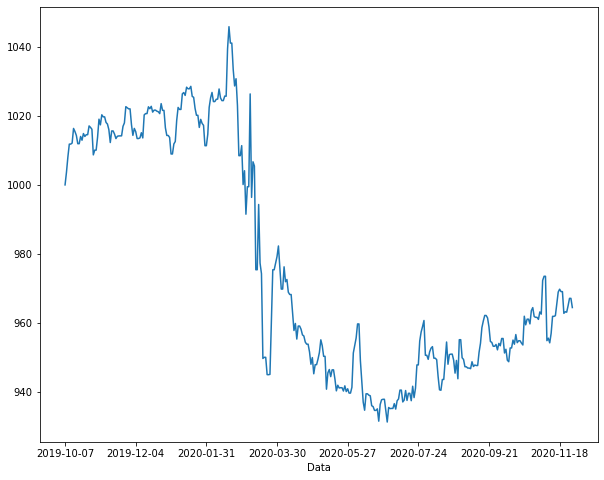

In [70]:
dfSMA['Saldo'].plot(figsize=(10,8))

# Métricas SMA

In [71]:
dfSMA['Retorno']=dfSMA['Saldo'].pct_change()
dfSMA['R. Acumulado'] = (1+dfSMA['Retorno']).cumprod()
dfSMA['Retorno'].iloc[0] = 0
dfSMA['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_SMA = (dfSMA['Retorno'].mean()*(255-0.01))/(dfSMA['Retorno'].std()*np.sqrt(255))
print(Sharpe_SMA)

-0.2860772798744325


In [27]:
#Retorno anualizado
Retorno_anualizadoSMA= (1+dfSMA['Retorno'].sum())**0.5
print(Retorno_anualizadoSMA)

0.9839740742486116


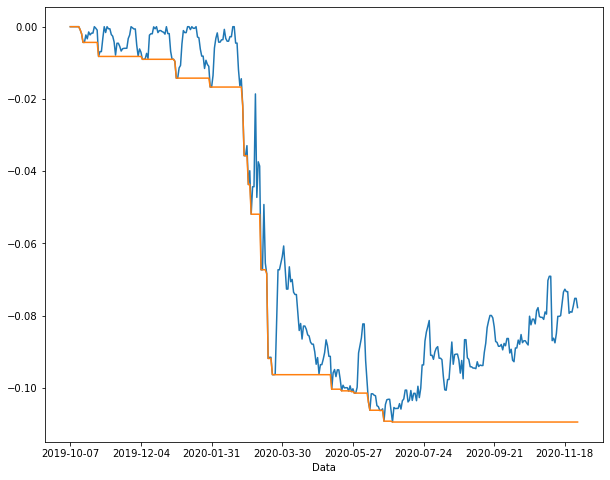

In [28]:
#MDD
Roll_Max2 = dfSMA['Saldo'].cummax()
Daily_Drawdown2 = dfSMA['Saldo']/Roll_Max2 - 1.0
MDDSMA = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSMA.plot(figsize=(10,8))

In [29]:
MDDSMA.min()

-0.10949040301663793

In [30]:
#Calmar
Calmar_SMA = (-dfSMA['Retorno'].mean()*255)/MDDSMA.min()
print(Calmar_SMA)

-0.205693583493743


# Benchmark ATR

In [72]:
amostraATR= amostra #definindo dataframe para aplicação da ATR

janela = 240 #dividino a janela de deslocamento
total=amostraATR.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosAtr=[]
diasAtr=[]
close=[]
sinal=[]
ATR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraATR.iloc[t:(janela)]
    inSample = amostraATR.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasAtr.extend(inSample.index)
    close.extend(inSample['Close'])
    ATR.extend(inSample['ATR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [73]:
#criando e organizando dataframe
dfATR = pd.DataFrame(diasAtr)
dfATR.columns=['Data']
dfATR.set_index('Data', inplace = True)
dfATR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfATR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfATR.insert(loc=2, column='ATR', value=ATR, allow_duplicates=False)
dfATR.insert(loc=3, column ='flag',value = 0, allow_duplicates=False)
saldo=1000

In [74]:
#simulando operações
saldo=1000
flag = 0
for i in np.arange(1,len(diasAtr)):
    
    if ATR[i]>0.008:
        flag = -1
        dfATR['flag'].iloc[i]= flag
    elif ATR[i] < 0.0065:
        flag = 1
        dfATR['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfATR['Close'].iloc[i]-dfATR['Close'].iloc[i-1])*9.19
        dfATR['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfATR['Close'].iloc[i-1]-dfATR['Close'].iloc[i])*9.19
        dfATR['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

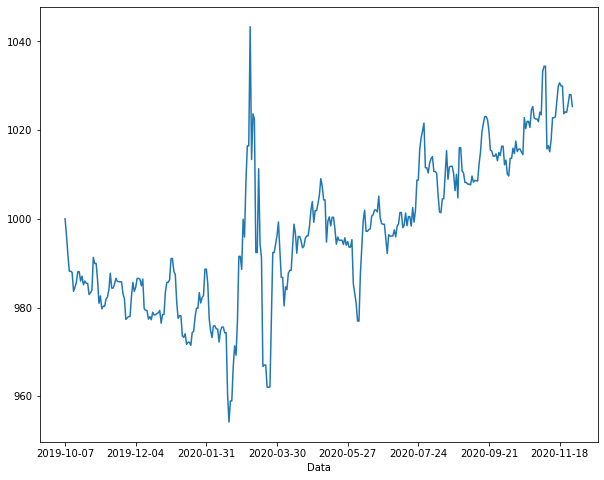

In [75]:
dfATR['Saldo'].plot(figsize=(10,8))

# Métricas ATR

In [35]:
dfATR['Retorno']=dfATR['Saldo'].pct_change()
dfATR['R. Acumulado'] = (1+dfATR['Retorno']).cumprod()
dfATR['Retorno'].iloc[0] = 0
dfATR['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
# Sharpe

Sharpe_ATR= (dfATR['Retorno'].mean()*(255-0.01))/(dfATR['Retorno'].std()*np.sqrt(255))
print(Sharpe_ATR)

0.26786016663300066


In [37]:
# Retorno anualizado
Retorno_anualizadoATR= (1+dfATR['Retorno'].sum())**0.5
print(Retorno_anualizadoATR)

1.0145229038895769


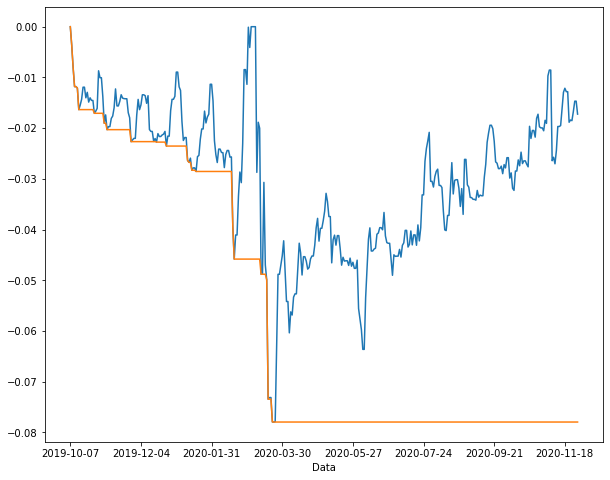

In [38]:
#MDD
Roll_Max2 = dfATR['Saldo'].cummax()
Daily_Drawdown2 = dfATR['Saldo']/Roll_Max2 - 1.0
MDDATR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDATR.plot(figsize=(10,8))

In [39]:
MDDATR.min()

-0.07794489159407103

In [40]:
#Calmar
Calmar_ATR = (-dfATR['Retorno'].mean()*255)/MDDATR.min()
print(Calmar_ATR)

0.2658738931920634


# Benchmark SAR

In [76]:
amostrasar = amostra #definindo dataframe

janela = 240 #tamanho da janela de deslocamento
total=amostrasar.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSar=[]
diasSar=[]
close=[]
sinal=[]
SAR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasar.iloc[t:(janela)]
    inSample = amostrasar.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSar.extend(inSample['body'])
    diasSar.extend(inSample.index)
    close.extend(inSample['Close'])
    SAR.extend(inSample['SAR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [77]:
#dataframe para retornos e métricas
dfSAR = pd.DataFrame(diasSar)
dfSAR.columns=['Data']
dfSAR.set_index('Data', inplace = True)
dfSAR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSAR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSAR.insert(loc=2, column='SAR', value=SAR, allow_duplicates=False)

In [78]:
saldo=1000 
for i in np.arange(1,len(diasSma)): #calculo retorno
    if SAR[i]< close[i]:
        saldo=saldo +(dfSAR['Close'].iloc[i]-dfSAR['Close'].iloc[i-1])*9.19
        dfSAR['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSAR['Close'].iloc[i-1]-dfSAR['Close'].iloc[i])*9.19
        dfSAR['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


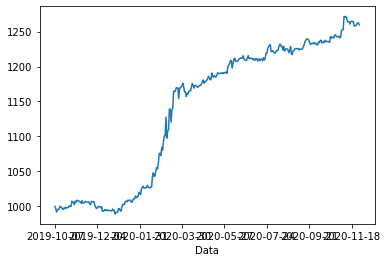

In [79]:
dfSAR['Saldo'].plot(fig=(10,8))

# Métricas SAR

In [45]:
dfSAR['Retorno']=dfSAR['Saldo'].pct_change()
dfSAR['R. Acumulado'] = (1+dfSAR['Retorno']).cumprod()

In [46]:
# Sharpe

Sharpe_SAR= (dfSAR['Retorno'].mean()*(255-0.01))/(dfSAR['Retorno'].std()*np.sqrt(255))
print(Sharpe_SAR)

2.438496970348925


In [47]:
# Retorno anualizado
Retorno_anualizadoSAR= (1+dfSAR['Retorno'].sum())**0.5
print(Retorno_anualizadoSAR)

1.1109373340648614


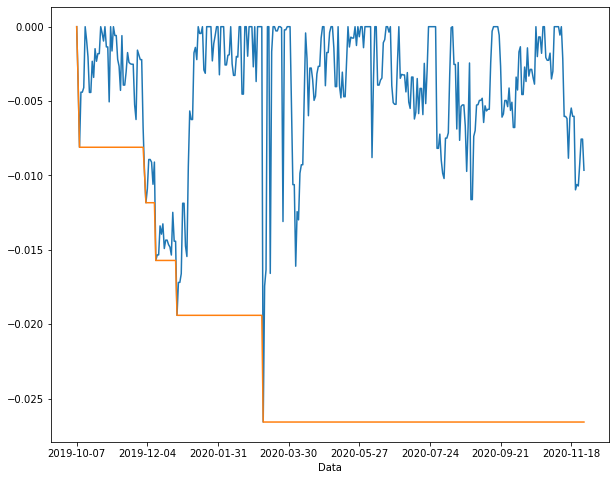

In [48]:
#MDD
Roll_Max2 = dfSAR['Saldo'].cummax()
Daily_Drawdown2 = dfSAR['Saldo']/Roll_Max2 - 1.0
MDDSAR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSAR.plot(figsize=(10,8))

In [49]:
MDDSAR.min()

-0.026578982230382908

In [50]:
#Calmar
Calmar_SAR = (-dfSAR['Retorno'].mean()*255)/MDDSAR.min()
print(Calmar_SAR)

6.25835869751006


# Benchmark CCI

In [80]:
amostraCCI=amostra 

janela = 240
total=amostraCCI.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosCci=[]
diasCci=[]
close=[]
sinal=[]
CCI=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraCCI.iloc[t:(janela)]
    inSample = amostraCCI.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosCci.extend(inSample['body'])
    diasCci.extend(inSample.index)
    close.extend(inSample['Close'])
    CCI.extend(inSample['CCI'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [81]:
dfCCI = pd.DataFrame(diasCci)
dfCCI.columns=['Data']
dfCCI.set_index('Data', inplace = True)
dfCCI.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfCCI.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfCCI.insert(loc=2, column='CCI', value=CCI, allow_duplicates=False)
dfCCI.insert(loc=3, column='flag',value=0,allow_duplicates=False)

In [82]:
saldo=1000
flag = 0
for i in np.arange(1,len(diasCci)):
    
    if CCI[i]>100:
        flag = 1
        dfCCI['flag'].iloc[i]= flag
    elif CCI[i] < -100:
        flag = -1
        dfCCI['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfCCI['Close'].iloc[i]-dfCCI['Close'].iloc[i-1])*9.19
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfCCI['Close'].iloc[i-1]-dfCCI['Close'].iloc[i])*9.19
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


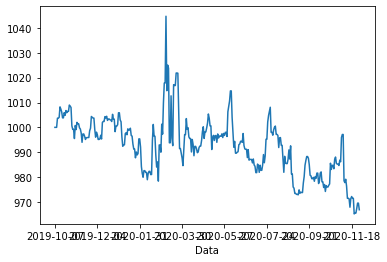

In [83]:
dfCCI['Saldo'].plot(fig=(10,8))

# Métricas CCI

In [55]:
dfCCI['Retorno']=dfCCI['Saldo'].pct_change()
dfCCI['R. Acumulado'] = (1+dfCCI['Retorno']).cumprod()
dfCCI['Retorno'].iloc[0] = 0
dfCCI['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
# Sharpe

Sharpe_CCI= (dfCCI['Retorno'].mean()*(255-0.01))/(dfCCI['Retorno'].std()*np.sqrt(255))
print(Sharpe_CCI)

-0.2710836056881442


In [57]:
# Retorno anualizado
Retorno_anualizadoCCI= (1+dfCCI['Retorno'].sum())**0.5
print(Retorno_anualizadoCCI)

0.9851279415908247


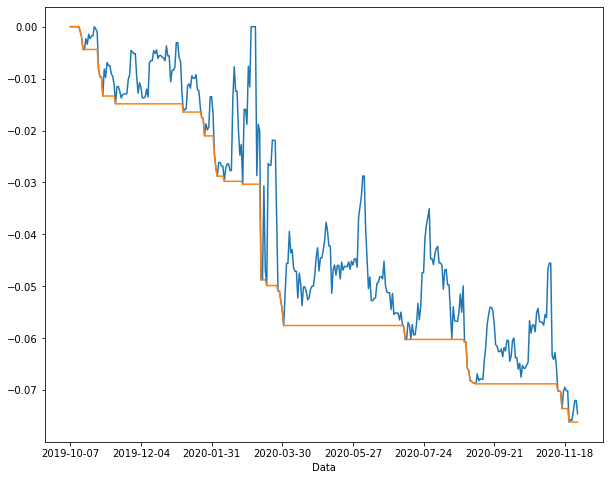

In [58]:
#MDD
Roll_Max2 = dfCCI['Saldo'].cummax()
Daily_Drawdown2 = dfCCI['Saldo']/Roll_Max2 - 1.0
MDDCCI = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDCCI.plot(figsize=(10,8))

In [59]:
MDDCCI.min()

-0.07613548208408394

In [60]:
#Calmar
Calmar_CCI= (-dfCCI['Retorno'].mean()*255)/MDDCCI.min()
print(Calmar_CCI)

-0.27466932637221486


#  faz-se o tuning utilizando o grid_search para rodar o random forest sem a tunagem a cada passo


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parametros
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90 , 100, 110],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state':[0,42]
}
# instanciando modelo
rf = RandomForestClassifier()
# Instanciando grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [24]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    

    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    
    
    window= window+60
    print(grid_search.best_params_)
    print(acuracia)

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 55.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 42}
0.5333333333333333
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 0}
0.6
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5833333333333334
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 200, 'random_state': 42}
0.5666666666666667
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400, 'random_state': 42}
0.55


# agora pegando os parametros que apresentaram uma maior acurácia no grid_search , faz-se o walkforward com eles

In [33]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
rf = RandomForestClassifier(random_state= 0,bootstrap = True, max_depth = 50, max_features= 3, min_samples_leaf = 3, min_samples_split= 10, n_estimators = 200)


In [35]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]
close =[]

In [36]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    rf.fit(X_treino,Y_treino)
    yrf_pred=rf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    close.extend(X_teste['Close'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)
# 0.5333333333333333
# 0.5833333333333334
# 0.6166666666666667
# 0.5
# 0.6
# 0.55

0.5666666666666667
0.5833333333333334
0.6666666666666666
0.5833333333333334
0.6333333333333333
0.6


# implementando a estratégia:

# defini de uma forma bem simples que o ganho/perda do dia seria a diferença de abertura - fechamento da vela
# se o valor predito fosse igual ao valor real da ordem ( 1 -> compra ; -1 -> venda), ele somaria os pips ao saldo caso estivesse correto ou subtrairia caso estivesse errado.



In [37]:
saldo = 1000


In [38]:
lucro = pd.DataFrame(dias)

In [39]:
lucro.columns=['Data']

In [40]:
lucro.set_index('Data', inplace = True)

In [41]:
lucro.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)

In [42]:
lucro.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [43]:
saldo=1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs((close[i-1]-close[i])*9.19)
        lucro.iloc[i] = saldo
         
    else:
        saldo = saldo - abs((close[i-1]-close[i])*9.19)
        lucro.iloc[i] = saldo     
       
    
#     print(saldo)

In [49]:
lucro

,Saldo
Data,
2019-10-07,1000.00000
2019-10-08,996.32400
2019-10-09,991.89442
2019-10-10,995.59799
2019-10-11,995.59799
...,...
2020-11-24,1283.16228
2020-11-25,1285.03704
2020-11-26,1287.16912


In [44]:
lucro['Retorno']=lucro['Saldo'].pct_change()

In [45]:
lucro['R. Acumulado'] = (1+lucro['Retorno']).cumprod()

In [46]:
lucro['Retorno'].iloc[0] = 0
lucro['R. Acumulado'].iloc[0]=0

In [47]:
lucro.head()

,Saldo,Retorno,R. Acumulado
Data,,,
2019-10-07,1000.00000,0.000000,0.000000
2019-10-08,996.32400,-0.003676,0.996324
2019-10-09,991.89442,-0.004446,0.991894
2019-10-10,995.59799,0.003734,0.995598
2019-10-11,995.59799,0.000000,0.995598


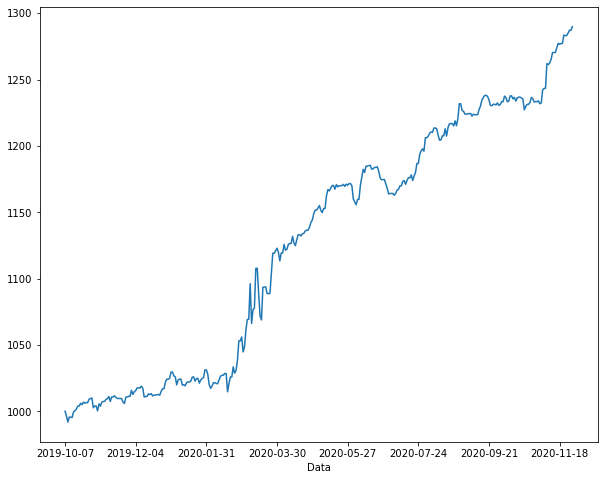

In [48]:
lucro['Saldo'].plot(figsize=(10,8))

# Métricas de desempenho


# Índice de Sharpe


In [55]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio1 = (lucro['Retorno'].mean()*(255-0.01) )/(lucro['Retorno'].std()*np.sqrt(255)) # mean = return_series.mean() * N -rf
print(Sharpe_Ratio1)

2.6211607407368067


# Retorno anualizado

In [56]:
Retorno_anualizado1 = (1+lucro['Retorno'].sum())**0.5

In [57]:
print(Retorno_anualizado1)

1.121613497066754


# Máximo Drawdown

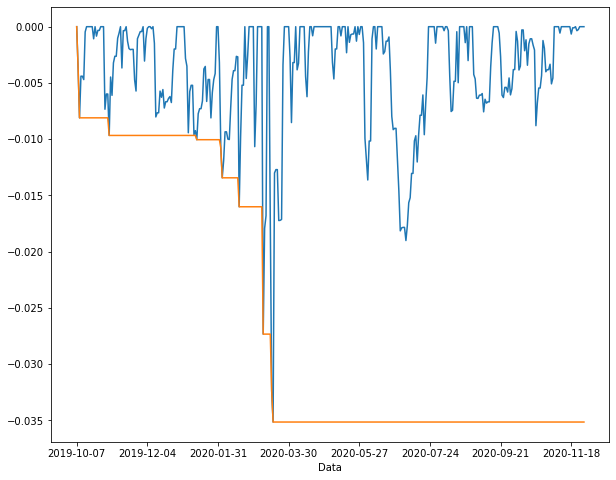

In [58]:
Roll_Max1 = lucro['Saldo'].cummax()
Daily_Drawdown1 = lucro['Saldo']/Roll_Max1 - 1.0
MDD1 = Daily_Drawdown1.cummin()
# Plotando o resultado
Daily_Drawdown1.plot(figsize =(10,8))
MDD1.plot(figsize=(10,8))

In [59]:
MDD1.min()

-0.03515847457261467

# Índice de Calmar

In [60]:
Calmar_Ratio1 = (-lucro['Retorno'].mean()*255)/MDD1.min()
print(Calmar_Ratio1)

5.198232525442406


# Calculando o walkforward com o grid_search a cada passo

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parametros
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state': [0, 42]
}
# definindo modelo
rf = RandomForestClassifier()
#instanciando grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [25]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [26]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]
close=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor
  
    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    pontos.extend(X_teste['body'])
    close.extend(X_teste['Close'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.5min finished


0.5666666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished


0.6333333333333333
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished


0.65
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.8min finished


0.55
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.8min finished


0.6166666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.2min finished


0.6


# Calculando retornos com WFA com grid search a cada passo

In [27]:
saldo = 1000


In [28]:
lucroWFA = pd.DataFrame(dias)
lucroWFA.columns=['Data']
lucroWFA.set_index('Data', inplace = True)
lucroWFA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroWFA.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [29]:
saldo=1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs((close[i-1]-close[i])*9.19)
        lucroWFA.iloc[i] = saldo
         
    else:
        saldo = saldo - abs((close[i-1]-close[i])*9.19)
        lucroWFA.iloc[i] = saldo     
       

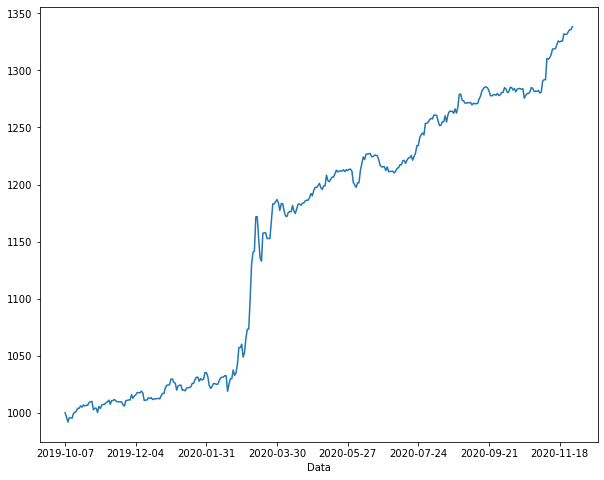

In [30]:
lucroWFA['Retorno']=lucroWFA['Saldo'].pct_change()
lucroWFA['R. Acumulado'] = (1+lucroWFA['Retorno']).cumprod()
lucroWFA['Retorno'].iloc[0] = 0
lucroWFA['R. Acumulado'].iloc[0]=0
lucroWFA['Saldo'].plot(figsize=(10,8))

In [31]:
lucroWFA.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [32]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00000,0.000000,0.000000
2019-10-08,-1,996.32400,-0.003676,0.996324
2019-10-09,-1,991.89442,-0.004446,0.991894
2019-10-10,-1,995.59799,0.003734,0.995598
2019-10-11,-1,995.59799,0.000000,0.995598
...,...,...,...,...
2020-11-24,-1,1331.66710,0.000097,1.331667
2020-11-25,-1,1333.54186,0.001408,1.333542
2020-11-26,-1,1335.67394,0.001599,1.335674


# Métricas de desempenho


# Índice de Sharpe

In [70]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio2 = (lucroWFA['Retorno'].mean()*(255-0.01))/(lucroWFA['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio2)

3.0997158858897835


# Retorno anualizado

In [71]:
Retorno_anualizado2 = (1+lucroWFA['Retorno'].sum())**0.5
print(Retorno_anualizado2)

1.1378575175165353


# Máximo Drawdown

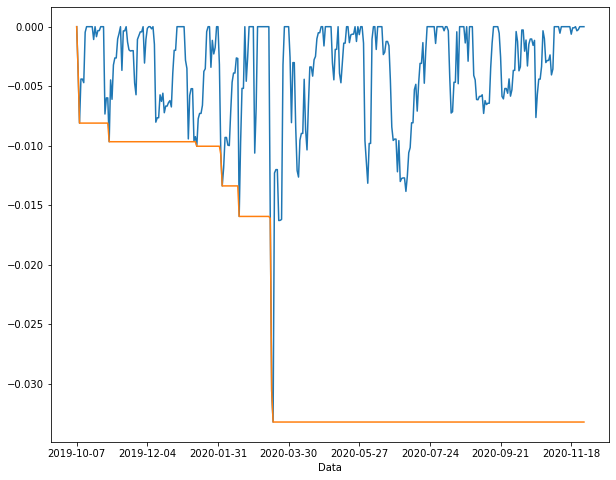

In [72]:
Roll_Max2 = lucroWFA['Saldo'].cummax()
Daily_Drawdown2 = lucroWFA['Saldo']/Roll_Max2 - 1.0
MDD2 = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDD2.plot(figsize=(10,8))

In [73]:
MDD2.min()

-0.033238191641624115

# Índice de Calmar

In [113]:
Calmar_Ratio2 = (-lucroWFA['Retorno'].mean()*255)/MDD2.min()
print(Calmar_Ratio2)

6.280721018775367


In [114]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1.00000,1000.00000,0.000000,0.000000
2019-10-08,996.32400,996.32400,-0.003676,0.996324
2019-10-09,991.89442,991.89442,-0.004446,0.991894
2019-10-10,995.59799,995.59799,0.003734,0.995598
2019-10-11,995.59799,995.59799,0.000000,0.995598
...,...,...,...,...
2020-11-24,1331.66710,1331.66710,0.000097,1.331667
2020-11-25,1333.54186,1333.54186,0.001408,1.333542
2020-11-26,1335.67394,1335.67394,0.001599,1.335674


# Fazendo o benchmark com o MACD

# Arrumando os dias da amostra

In [84]:
#seguindo exemplo do tcc do andre, eu coloquei a amostra com valor de 600b
amostraMACD = amostra

# Calculando o MACD


In [85]:
# Calculando a EMA com período menor
ShortEMA = amostraMACD['Close'].ewm(span =12, adjust = False).mean()
# Calculando a EMA com período maior
LongEMA = amostraMACD['Close'].ewm(span = 26, adjust = False).mean()
# Calculando o sinal MACD
MACD = ShortEMA - LongEMA
# Calculando a linha do sinal
sinal = MACD.ewm(span = 9, adjust = False).mean()


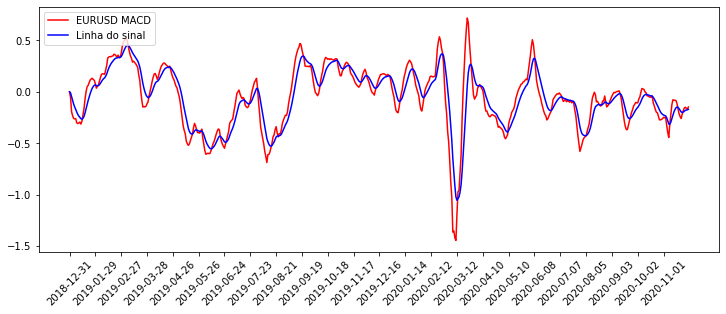

In [86]:
#plotando o gráfico
plt.figure(figsize = (12.2 , 4.5))
plt.plot(amostraMACD.index, MACD, label='EURUSD MACD', color = 'red')
plt.plot(amostraMACD.index, sinal, label = 'Linha do sinal', color = 'blue')
plt.xticks(amostraMACD.index[::25],rotation = 45)
plt.legend(loc='upper left')
plt.show()


# Adicionando a coluna com os valores do MACD no dataframe amostraMACD

In [87]:
amostraMACD['MACD'] = MACD
amostraMACD['Linha de Sinal'] = sinal
#visualizando os dados
amostraMACD.head()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_95,return_96,lag_return_96,sobe_desce,price yesterday,change,invested_SMA,retorno,MACD,Linha de Sinal
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,109.556,109.556,109.556,109.556,0.0000,0.0,0.0,0.0,112.65486,111.71865,...,-0.003333,-0.018544,0.004707,-1,NaN,NaN,-1,NaN,0.000000,0.000000
2019-01-01,109.648,109.726,108.707,108.874,254073.7902,-77.4,7.8,16.7,112.56856,111.49650,...,0.005959,-0.021392,-0.003333,-1,109.556,0.993775,-1,NaN,-0.054405,-0.010881
2019-01-02,108.872,108.898,104.736,107.646,340032.6300,-122.6,2.6,291.0,112.45312,111.21030,...,0.001224,-0.038162,0.005959,1,108.874,0.988721,-1,NaN,-0.194369,-0.047579
2019-01-03,107.646,108.589,107.512,108.518,304510.0653,87.2,7.1,13.4,112.35366,110.97235,...,0.000000,-0.031556,0.001224,-1,107.646,1.008101,-1,NaN,-0.232252,-0.084513
2019-01-04,108.518,108.518,108.518,108.518,0.0000,0.0,0.0,0.0,112.24274,110.71880,...,-0.001910,-0.031556,0.000000,1,108.518,1.000000,-1,NaN,-0.259286,-0.119468


In [88]:
#logica MACD para trade
amostraMACD['price yesterday'] = amostraMACD['Close'].shift(1)
amostraMACD['change'] = (amostraMACD['Close']/amostraMACD['price yesterday'])

amostraMACD['invested_MACD'] = [1 if amostraMACD.loc[i,'MACD'] > amostraMACD.loc[i,'Linha de Sinal'] else -1 for i in amostraMACD.index]
MACD=amostraMACD[amostraMACD['invested_MACD']==1]
amostraMACD['retorno']=np.cumprod(MACD['change'])


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Criando a função que sinalizará a compra ou venda 

In [89]:
def buy_sell(sinal):
    buy = []
    sell = []
    flag = -1
    
    for i in range(0,len(sinal)):
        if sinal['MACD'][i] > sinal['Linha de Sinal'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(sinal['Close'][i])
                flag = 1
            else:
                buy.append(np.nan)

        elif sinal['MACD'][i] < sinal['Linha de Sinal'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(sinal['Close'][i])
                flag = 0
            else:
                sell.append(np.nan) 
        else:
            sell.append(np.nan)
            buy.append(np.nan)
    return (buy,sell)

In [90]:
# criando as colunas buy e sell
a = buy_sell(amostraMACD)
amostraMACD['Preço para Buy'] = a[0]
amostraMACD['Preço para Sell'] = a[1]

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


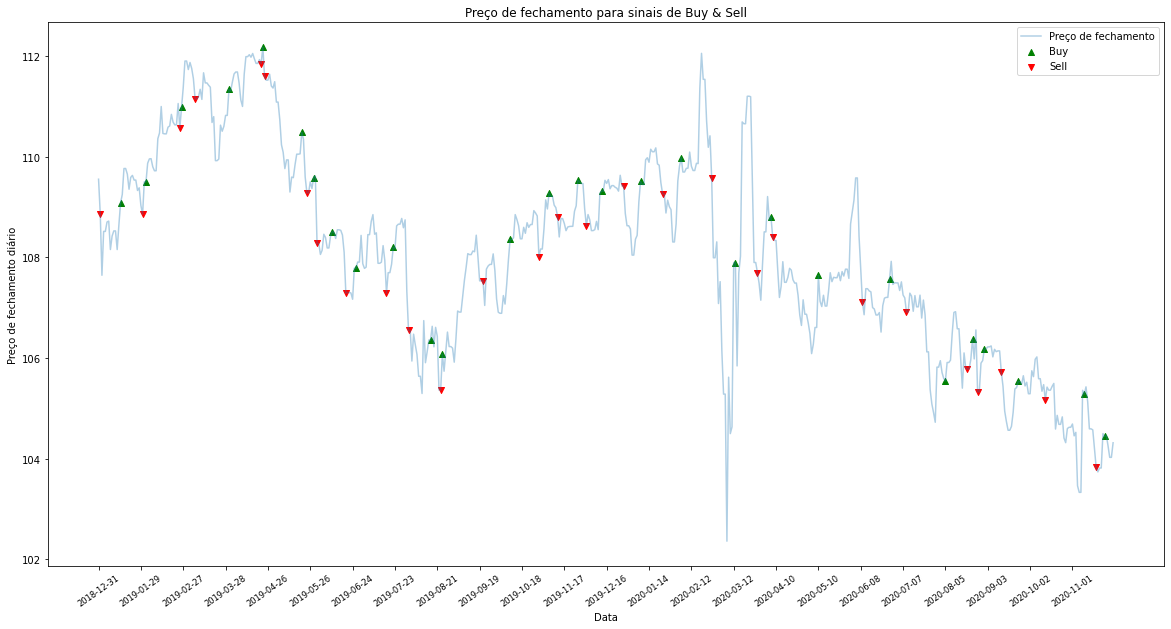

In [91]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(amostraMACD.index, amostraMACD['Preço para Buy'], color = 'green', label = 'Buy', marker = '^', alpha=1)
plt.scatter(amostraMACD.index, amostraMACD['Preço para Sell'], color = 'red', label = 'Sell', marker = 'v', alpha=1)

plt.plot(amostraMACD['Close'], label='Preço de fechamento', alpha =0.35)
plt.title('Preço de fechamento para sinais de Buy & Sell')
plt.xticks(amostraMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Preço de fechamento diário')
plt.legend( loc = 'upper right')
plt.show()

# Separando os dias de operações conforme o walkforward

In [92]:
janela = 240
total=amostraMACD.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward


In [93]:
#listas para receberem valores
pontosMacd=[]
diasMacd=[]
buy =[]
sell= []
close=[]
sinal=[]
MACDl=[]
yprice=[]
change=[]
invistedMACD=[]
retorno=[]

In [94]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraMACD.iloc[t:(janela)]
    inSample = amostraMACD.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosMacd.extend(inSample['body'])
    diasMacd.extend(inSample.index)
    buy.extend(inSample['Preço para Buy'])
    sell.extend(inSample['Preço para Sell'])
    close.extend(inSample['Close'])
    sinal.extend(inSample['Linha de Sinal'])  
    MACDl.extend(inSample['MACD'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedMACD.extend(inSample['invested_MACD'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [95]:
dfMACD = pd.DataFrame(diasMacd)
dfMACD.columns=['Data']
dfMACD.set_index('Data', inplace = True)
dfMACD.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfMACD.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfMACD.insert(loc=2, column='MACD', value=MACDl, allow_duplicates=False)
dfMACD.insert(loc=3, column='Linha de Sinal', value=sinal, allow_duplicates=False)
dfMACD.insert(loc=4, column='Buy', value=buy, allow_duplicates=False)
dfMACD.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfMACD.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfMACD.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfMACD.insert(loc=7, column='invisted macd', value=invistedMACD, allow_duplicates=False)


In [96]:
saldo = 1000

In [97]:
dfMACD.head(50)

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-07,1000,107.073,-0.038004,0.081508,107.242,0.998424,NaN,-1,NaN
2019-10-08,1000,107.473,-0.021575,0.060891,107.073,1.003736,NaN,-1,NaN
2019-10-09,1000,107.955,0.029992,0.054712,107.473,1.004485,NaN,-1,NaN
2019-10-10,1000,108.358,0.102201,0.064209,107.955,1.003733,1.046693,1,108.358
2019-10-11,1000,108.358,0.157610,0.082889,108.358,1.000000,1.046693,1,NaN
2019-10-13,1000,108.391,0.201857,0.106683,108.358,1.000305,1.047012,1,NaN
2019-10-14,1000,108.852,0.270999,0.139546,108.391,1.004253,1.051465,1,NaN
2019-10-15,1000,108.755,0.314344,0.174506,108.852,0.999109,1.050528,1,NaN
2019-10-16,1000,108.631,0.334829,0.206570,108.755,0.998860,1.049330,1,NaN


In [98]:
saldo=1000
for i in np.arange(1,len(diasMacd)):
    if invistedMACD[i]==1:
        saldo=saldo+(((dfMACD['Close'].iloc[i]-dfMACD['yesterday price'].iloc[i]))*(9.19))
        dfMACD['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + ((dfMACD['yesterday price'].iloc[i]-dfMACD['Close'].iloc[i]))*(9.19)
        dfMACD['Saldo'].iloc[i]=saldo
       

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [99]:
dfMACD.head(100)


,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-07,1000.00000,107.073,-0.038004,0.081508,107.242,0.998424,NaN,-1,NaN
2019-10-08,996.32400,107.473,-0.021575,0.060891,107.073,1.003736,NaN,-1,NaN
2019-10-09,991.89442,107.955,0.029992,0.054712,107.473,1.004485,NaN,-1,NaN
2019-10-10,995.59799,108.358,0.102201,0.064209,107.955,1.003733,1.046693,1,108.358
2019-10-11,995.59799,108.358,0.157610,0.082889,108.358,1.000000,1.046693,1,NaN
...,...,...,...,...,...,...,...,...,...
2020-01-26,1008.42723,108.884,0.067801,0.172264,109.267,0.996495,NaN,-1,NaN
2020-01-27,1006.09297,109.138,0.034759,0.144763,108.884,1.002333,NaN,-1,NaN
2020-01-28,1007.26929,109.010,-0.001735,0.115463,109.138,0.998827,NaN,-1,NaN


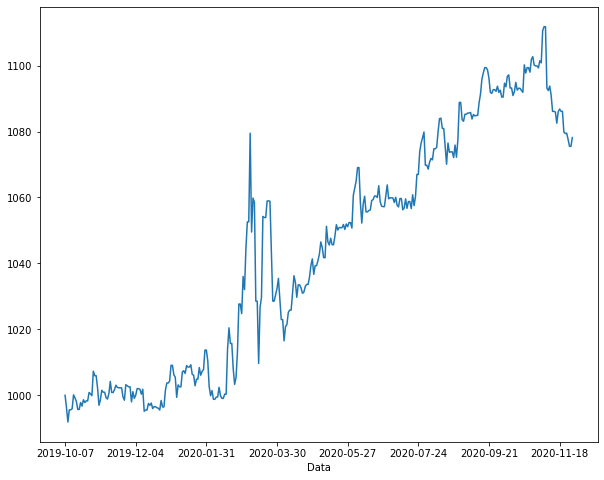

In [100]:
dfMACD['Saldo'].plot(figsize=(10,8))

In [187]:
#calculando o retorno
dfMACD['Retorno']=dfMACD['Saldo'].pct_change()
dfMACD['R. Acumulado'] = (dfMACD['Retorno']).cumprod()

In [188]:
dfMACD

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy,Retorno,R. Acumulado
Data,,,,,,,,,,,
2019-10-07,1000.00000,107.073,-0.038004,0.081508,107.242,0.998424,NaN,-1,NaN,NaN,NaN
2019-10-08,996.32400,107.473,-0.021575,0.060891,107.073,1.003736,NaN,-1,NaN,-0.003676,-3.676000e-03
2019-10-09,991.89442,107.955,0.029992,0.054712,107.473,1.004485,NaN,-1,NaN,-0.004446,1.634321e-05
2019-10-10,995.59799,108.358,0.102201,0.064209,107.955,1.003733,1.046693,1,108.358,0.003734,6.102286e-08
2019-10-11,995.59799,108.358,0.157610,0.082889,108.358,1.000000,1.046693,1,NaN,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,1079.51188,104.461,-0.157422,-0.189109,104.447,1.000134,1.072071,1,NaN,0.000119,-0.000000e+00
2020-11-25,1077.63712,104.257,-0.149774,-0.181242,104.461,0.998047,1.069977,1,NaN,-0.001737,0.000000e+00
2020-11-26,1075.50504,104.025,-0.160582,-0.177110,104.257,0.997775,1.067596,1,NaN,-0.001978,-0.000000e+00


# Calculando as métricas de desempenho

# Índice de Sharpe

In [189]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio3 = (dfMACD['Retorno'].mean()*(255-0.01)) /(dfMACD['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio3)

0.7578983634414582


# Retorno Anualizado

In [190]:
Retorno_anualizado3 = (1+dfMACD['Retorno'].sum())**0.5
print(Retorno_anualizado3)

1.0388169928671878


# Máximo Drawdown

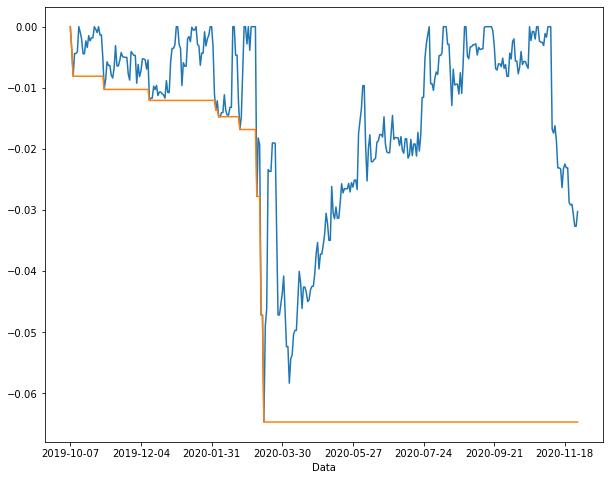

In [191]:
Roll_Max3 = dfMACD['Saldo'].cummax()
Daily_Drawdown3 = dfMACD['Saldo']/Roll_Max3 - 1.0
MDD3 = Daily_Drawdown3.cummin()
# Plotando o resultado
Daily_Drawdown3.plot(figsize =(10,8))
MDD3.plot(figsize=(10,8))

In [192]:
MDD3.min()

-0.06467572465226512

# Índice de Calmar

In [193]:
Calmar_Ratio3 = -(dfMACD['Retorno'].mean()*255)/MDD3.min()
print(Calmar_Ratio3)

0.8691696656035459


# Testando para SVM

# Primeiro utilizando o SVM sem o grid_search()

In [49]:
#fazendo os imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [130]:
amostra

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_96,sobe_desce,MACD,Linha de Sinal,Preço para Buy,Preço para Sell,price yesterday,change,invested_MACD,retorno
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,109.556,109.556,109.556,109.556,0.0000,0.0,0.0,0.0,112.65486,111.71865,...,0.004707,-1,0.000000,0.000000,NaN,NaN,NaN,NaN,-1,NaN
2019-01-01,109.648,109.726,108.707,108.874,254073.7902,-7740.0,780.0,1670.0,112.56856,111.49650,...,-0.003333,-1,-0.054405,-0.010881,NaN,108.874,109.556,0.993775,-1,NaN
2019-01-02,108.872,108.898,104.736,107.646,340032.6300,-12260.0,260.0,29100.0,112.45312,111.21030,...,0.005959,1,-0.194369,-0.047579,NaN,NaN,108.874,0.988721,-1,NaN
2019-01-03,107.646,108.589,107.512,108.518,304510.0653,8720.0,710.0,1340.0,112.35366,110.97235,...,0.001224,-1,-0.232252,-0.084513,NaN,NaN,107.646,1.008101,-1,NaN
2019-01-04,108.518,108.518,108.518,108.518,0.0000,0.0,0.0,0.0,112.24274,110.71880,...,0.000000,1,-0.259286,-0.119468,NaN,NaN,108.518,1.000000,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,104.439,104.597,104.255,104.461,116934.7191,220.0,1360.0,1840.0,104.85070,104.34200,...,-0.001116,-1,-0.157422,-0.189109,NaN,NaN,104.447,1.000134,1,1.072071
2020-11-25,104.453,104.472,104.218,104.257,108123.1215,-1960.0,190.0,390.0,104.82288,104.33220,...,-0.000445,-1,-0.149774,-0.181242,NaN,NaN,104.461,0.998047,1,1.069977
2020-11-26,104.266,104.281,103.906,104.025,88681.0303,-2410.0,150.0,1190.0,104.79448,104.30735,...,0.003449,-1,-0.160582,-0.177110,NaN,NaN,104.257,0.997775,1,1.067596


In [50]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [51]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

In [52]:
clf = make_pipeline(StandardScaler(), SVC(C= 1, gamma= 'auto', kernel= 'rbf'))

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    clf.fit(X_treino,Y_treino)
    yrf_pred=clf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)

0.5666666666666667
0.65
0.6666666666666666
0.6
0.5833333333333334
0.6


# Calculando os retornos

In [53]:
lucroSvm = pd.DataFrame(dias)
lucroSvm.columns=['Data']
lucroSvm.set_index('Data', inplace = True)
lucroSvm.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvm.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [54]:
saldo =1000

In [55]:
saldo=1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs((close[i-1]-close[i])*9.19)
        lucroSvm.iloc[i] = saldo
         
    else:
        saldo = saldo - abs((close[i-1]-close[i])*9.19)
        lucroSvm.iloc[i] = saldo     
       

In [56]:
lucroSvm

,Saldo
Data,
2019-10-07,1000.00000
2019-10-08,996.32400
2019-10-09,991.89442
2019-10-10,995.59799
2019-10-11,995.59799
...,...
2020-11-24,1275.31402
2020-11-25,1277.18878
2020-11-26,1279.32086


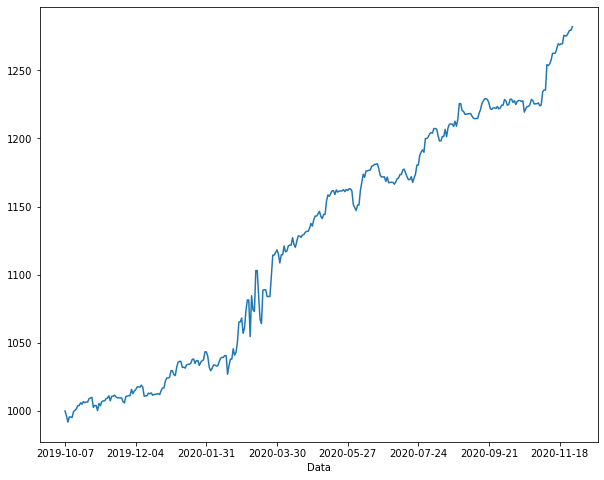

In [57]:
lucroSvm['Retorno']=lucroSvm['Saldo'].pct_change()
lucroSvm['R. Acumulado'] = (1+lucroSvm['Retorno']).cumprod()
lucroSvm['Retorno'].iloc[0] = 0
lucroSvm['R. Acumulado'].iloc[0]=0
lucroSvm['Saldo'].plot(figsize=(10,8))

In [83]:
lucroSvm.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [84]:
lucroSvm

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00000,0.000000,0.000000
2019-10-08,-1,996.32400,-0.003676,0.996324
2019-10-09,-1,991.89442,-0.004446,0.991894
2019-10-10,-1,995.59799,0.003734,0.995598
2019-10-11,-1,995.59799,0.000000,0.995598
...,...,...,...,...
2020-11-24,-1,1275.31402,0.000101,1.275314
2020-11-25,-1,1277.18878,0.001470,1.277189
2020-11-26,-1,1279.32086,0.001669,1.279321


# Métricas de desempenho


# Índice de Sharpe

In [85]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio4 =( lucroSvm['Retorno'].mean()*(255-0.01)) /(lucroSvm['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio4)

2.5474059800220172


# Retorno anualizado

In [86]:
Retorno_anualizado4 = (1+lucroSvm['Retorno'].sum())**0.5
print(Retorno_anualizado4)

1.1189002696466157


# Máximo Drawdown

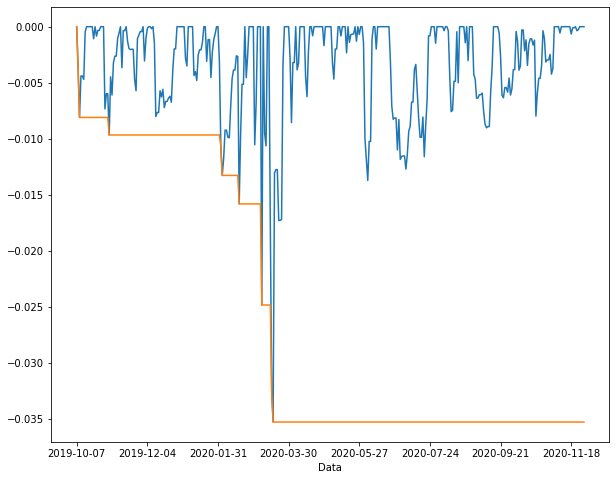

In [87]:
Roll_Max4 = lucroSvm['Saldo'].cummax()
Daily_Drawdown4 = lucroSvm['Saldo']/Roll_Max4 - 1.0
MDD4 = Daily_Drawdown4.cummin()
# Plotando o resultado
Daily_Drawdown4.plot(figsize =(10,8))
MDD4.plot(figsize=(10,8))

In [88]:
MDD4.min()

-0.03530844915981046

# Índice de Calmar

In [89]:
Calmar_Ratio4 = -lucroSvm['Retorno'].mean()*255/MDD4.min()
print(Calmar_Ratio4)

5.054199643870932


# Testando SVM com grid_search a cada passo do WFA

In [58]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [59]:
C = [x for x in np.logspace(start = 2**-15, stop = 2**5)]
gamma =  [x for x in np.logspace(start = 2**-15, stop = 2**3)]

In [60]:
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parametros
param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['rbf']} 
# instanciando modelo de machine learning
clf = SVC()
# Instanciando o grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [61]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor

    grid_search.fit(X_treino, Y_treino)
    clf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, clf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(clf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)
    print(grid_search.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   46.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5666666666666667
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6333333333333333
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   42.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6666666666666666
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6
{'C': 1.0000702717894114, 'gamma': 1.4564487290670938, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.0s


0.6
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   41.9s finished


# Calculando os retornos

In [62]:
lucroSvmg = pd.DataFrame(dias)
lucroSvmg.columns=['Data']
lucroSvmg.set_index('Data', inplace = True)
lucroSvmg.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvmg.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [63]:
saldo=1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs((close[i-1]-close[i])*9.19)
        lucroSvmg.iloc[i] = saldo
         
    else:
        saldo = saldo - abs((close[i-1]-close[i])*9.19)
        lucroSvmg.iloc[i] = saldo     
       

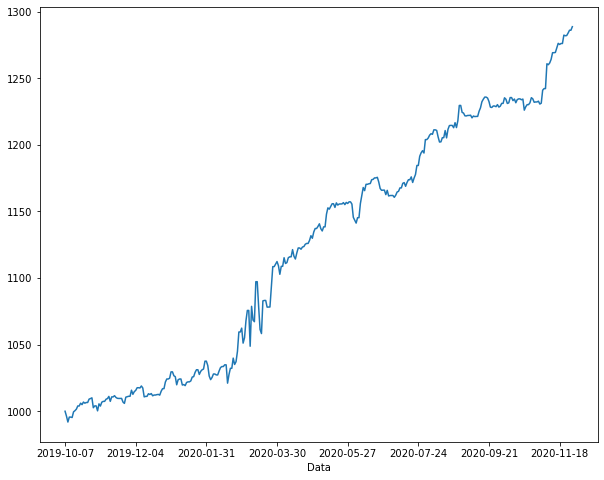

In [64]:
lucroSvmg['Retorno']=lucroSvmg['Saldo'].pct_change()
lucroSvmg['R. Acumulado'] = (1+lucroSvmg['Retorno']).cumprod()
lucroSvmg['Retorno'].iloc[0] = 0
lucroSvmg['R. Acumulado'].iloc[0]=0
lucroSvmg['Saldo'].plot(figsize=(10,8))

In [65]:
lucroSvmg.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [66]:
lucroSvmg

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00000,0.000000,0.000000
2019-10-08,-1,996.32400,-0.003676,0.996324
2019-10-09,-1,991.89442,-0.004446,0.991894
2019-10-10,-1,995.59799,0.003734,0.995598
2019-10-11,-1,995.59799,0.000000,0.995598
...,...,...,...,...
2020-11-24,-1,1282.07786,0.000100,1.282078
2020-11-25,-1,1283.95262,0.001462,1.283953
2020-11-26,-1,1286.08470,0.001661,1.286085


# Métricas de Desempenho

# Índice de Sharpe

In [99]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio5 = ((255-0.01)*lucroSvmg['Retorno'].mean()) /(lucroSvmg['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio5)

2.592385007003879


# Retorno Anualizado

In [100]:
Retorno_anualizado5 = (1+lucroSvmg['Retorno'].sum())**0.5
print(Retorno_anualizado5)

1.121261049843757


# Máximo Drawdown

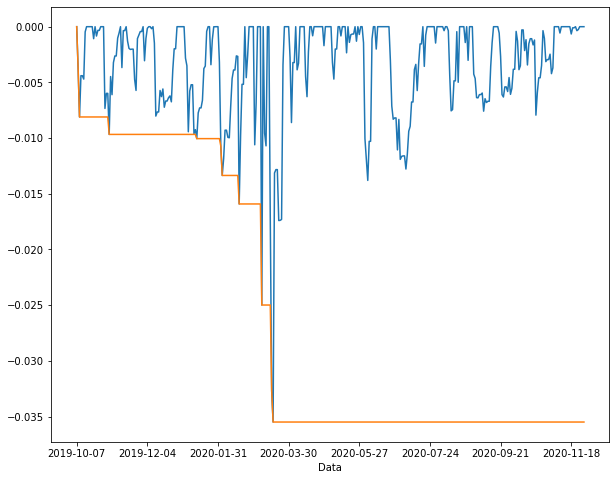

In [101]:
Roll_Max5 = lucroSvmg['Saldo'].cummax()
Daily_Drawdown5 = lucroSvmg['Saldo']/Roll_Max5 - 1.0
MDD5 = Daily_Drawdown5.cummin()
# Plotando o resultado
Daily_Drawdown5.plot(figsize =(10,8))
MDD5.plot(figsize=(10,8))

In [102]:
MDD5.min()

-0.035494753254942

# Índice de Calmar

In [103]:
Calmar_Ratio5 = -(lucroSvmg['Retorno'].mean()*255)/MDD5.min()
print(Calmar_Ratio5)

5.133209149762944


# Gráfico retornos

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


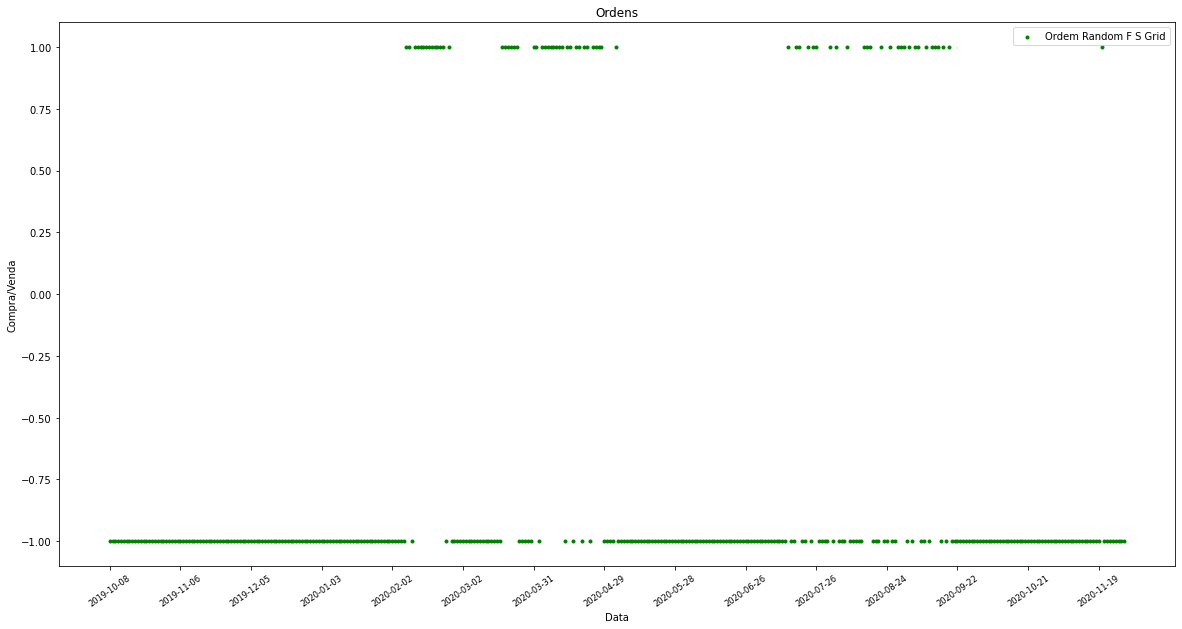

In [204]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


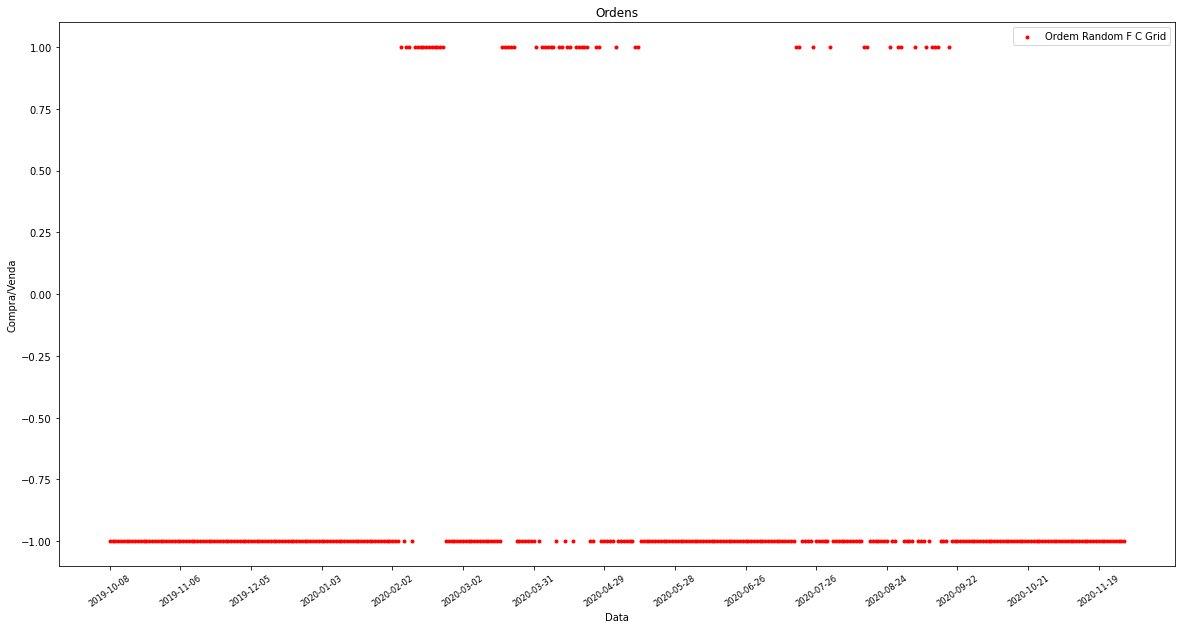

In [92]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


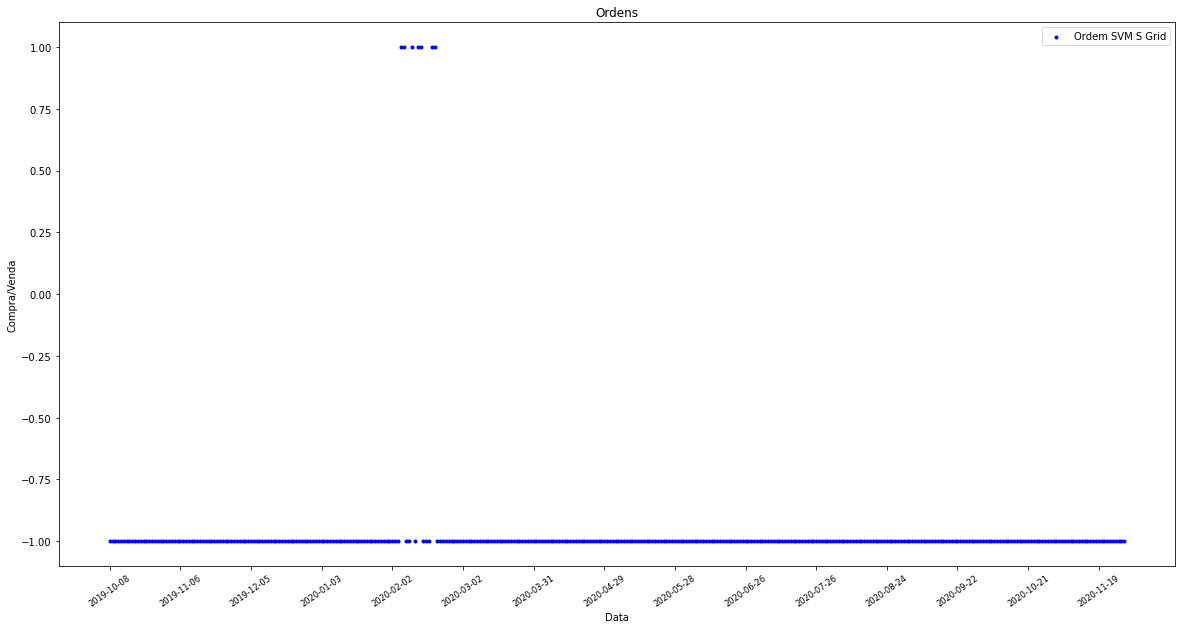

In [274]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


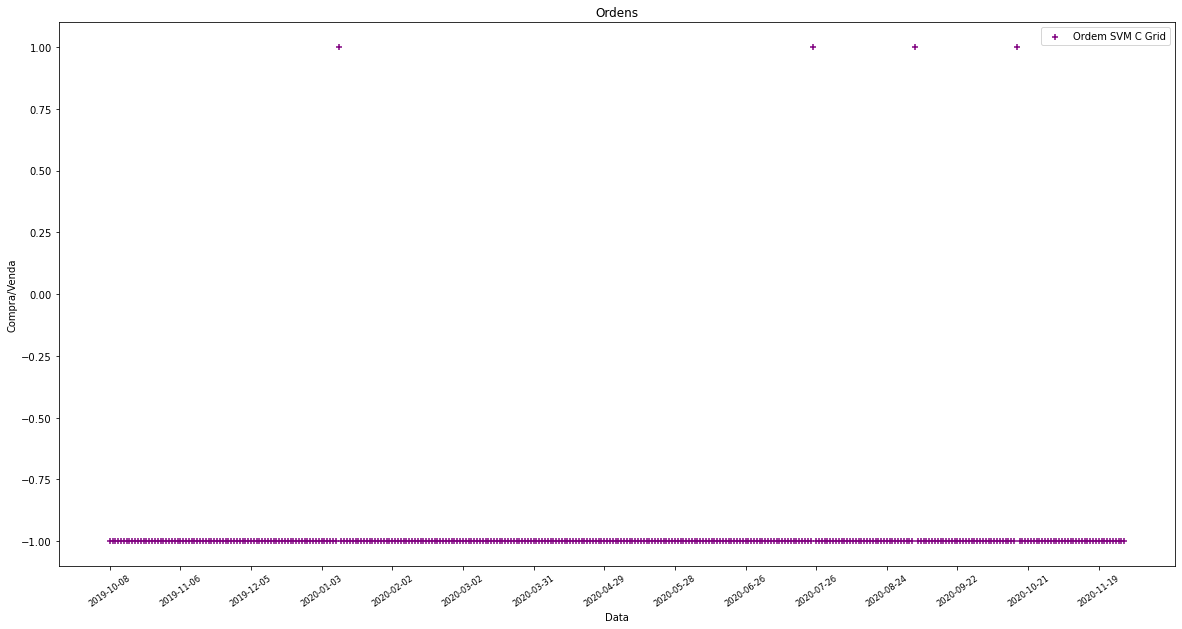

In [227]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '.', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


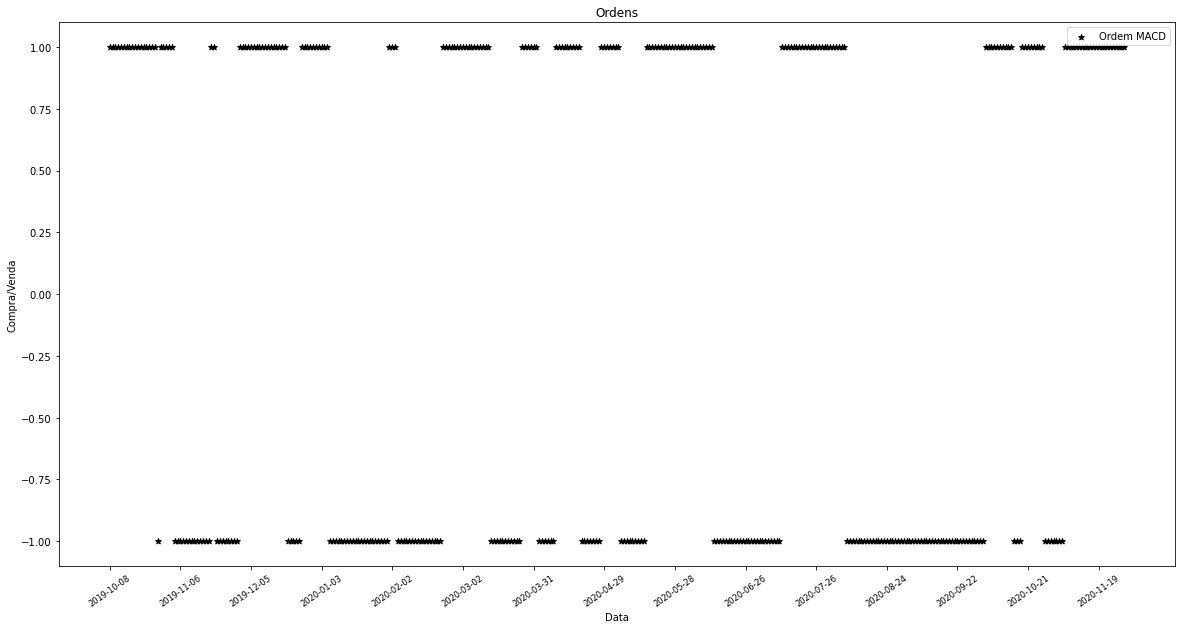

In [303]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(dfMACD.index, dfMACD['invisted macd'], color = 'black', label = 'Ordem MACD', marker = '*', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

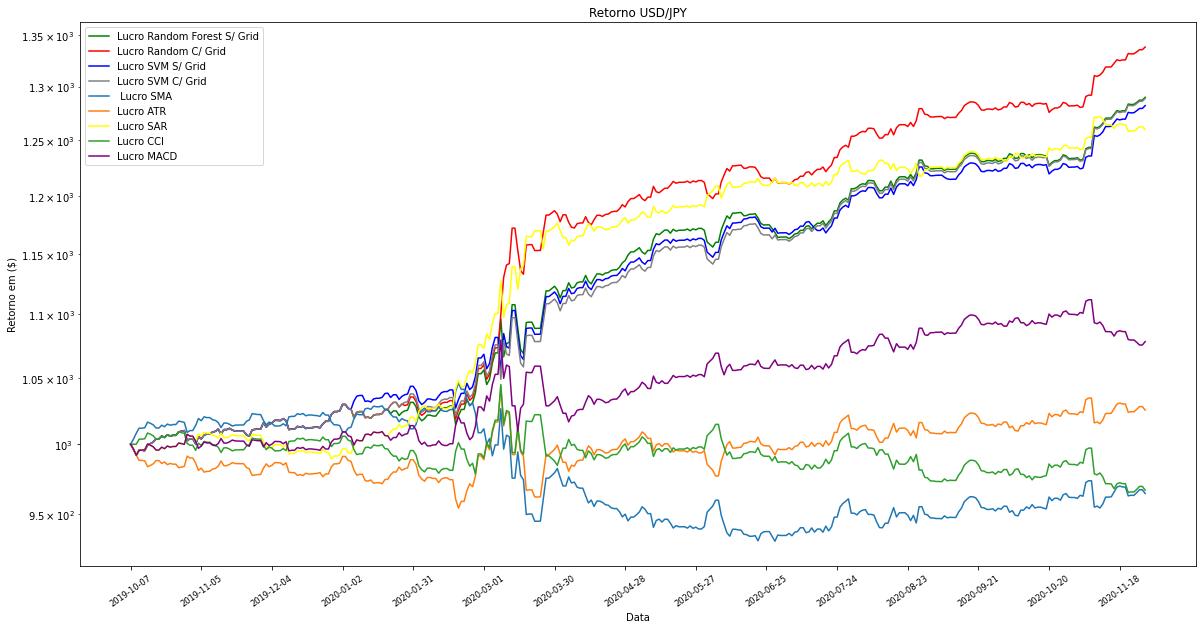

In [101]:
#Visualizando graficamente os retornos de cada estratégia
plt.figure(figsize= (20,10))
plt.plot(lucro.index, lucro['Saldo'], color = 'green', label = 'Lucro Random Forest S/ Grid', alpha=1)
plt.plot(lucroWFA.index, lucroWFA['Saldo'], color = 'red', label = 'Lucro Random C/ Grid', alpha=1)
plt.plot(lucroSvm.index, lucroSvm['Saldo'], color = 'blue', label = 'Lucro SVM S/ Grid', alpha=1)
plt.plot(lucroSvmg.index, lucroSvmg['Saldo'], color = 'gray', label = 'Lucro SVM C/ Grid', alpha=1)
plt.plot(dfSMA.index, dfSMA['Saldo'], label = ' Lucro SMA', alpha =1)
plt.plot(dfATR.index, dfATR['Saldo'], label = 'Lucro ATR', alpha = 1)
plt.plot(dfSAR.index, dfSAR['Saldo'], color='yellow', label = 'Lucro SAR', alpha =1)
plt.plot(dfCCI.index, dfCCI['Saldo'], label = 'Lucro CCI', alpha =1)
plt.plot(dfMACD['Saldo'], label='Lucro MACD',color='purple', alpha =1)
plt.title('Retorno USD/JPY')
plt.yscale("log")
plt.xticks(dfMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Retorno em ($)')
plt.legend( loc = 'upper left')
plt.show()

# Criando DataFrame com os índices

In [195]:
sharpe= [Sharpe_Ratio1,Sharpe_Ratio2,Sharpe_Ratio3,Sharpe_Ratio4,Sharpe_Ratio5, Sharpe_SMA, Sharpe_ATR, Sharpe_SAR, Sharpe_CCI]
calmar=[Calmar_Ratio1,Calmar_Ratio2,Calmar_Ratio3,Calmar_Ratio4,Calmar_Ratio5, Calmar_SMA, Calmar_ATR, Calmar_SAR, Calmar_CCI]
retornoa=[Retorno_anualizado1,Retorno_anualizado2,Retorno_anualizado3,Retorno_anualizado4,Retorno_anualizado5,Retorno_anualizadoSMA, Retorno_anualizadoATR, Retorno_anualizadoSAR,Retorno_anualizadoCCI]
estrategias=['Random Forest sem grid','Random Forest Com Grid','MACD','SVM sem grid','SVM com grid','SMA', 'ATR', 'SAR', 'CCI']
MDD=[MDD1.min(),MDD2.min(),MDD3.min(),MDD4.min(),MDD5.min(), MDDSMA.min(),MDDATR.min(),MDDSAR.min(),MDDCCI.min()]

In [196]:
dfRetorno=pd.DataFrame(estrategias)

In [197]:
dfRetorno.columns=['Estratégia']

In [198]:
dfRetorno.set_index('Estratégia', inplace=True)

In [199]:
dfRetorno.insert(loc=0, column='Sharpe', value=sharpe, allow_duplicates=False)
dfRetorno.insert(loc=1, column='Calmar', value=calmar, allow_duplicates=False)
dfRetorno.insert(loc=2, column='Retorno Anualizado', value=retornoa, allow_duplicates=False)
dfRetorno.insert(loc=3, column='Máximo DrawDown', value=MDD, allow_duplicates=False)

In [200]:
dfRetorno

,Sharpe,Calmar,Retorno Anualizado,Máximo DrawDown
Estratégia,,,,
Random Forest sem grid,2.621161,5.198233,1.121613,-0.035158
Random Forest Com Grid,3.099716,6.280721,1.137858,-0.033238
MACD,0.757898,0.869170,1.038817,-0.064676
SVM sem grid,2.547406,5.054200,1.118900,-0.035308
SVM com grid,2.592385,5.133209,1.121261,-0.035495
SMA,-0.286077,-0.205694,0.983974,-0.109490
ATR,0.267860,0.265874,1.014523,-0.077945
SAR,2.438497,6.258359,1.110937,-0.026579
CCI,-0.271084,-0.274669,0.985128,-0.076135
